In [235]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [236]:
# Define a scalar function f(x), which accepts a scalar x and returns a scalar y
def f(x):
    return 3*x**2 - 4*x + 5

In [237]:
f(3.0)

20.0

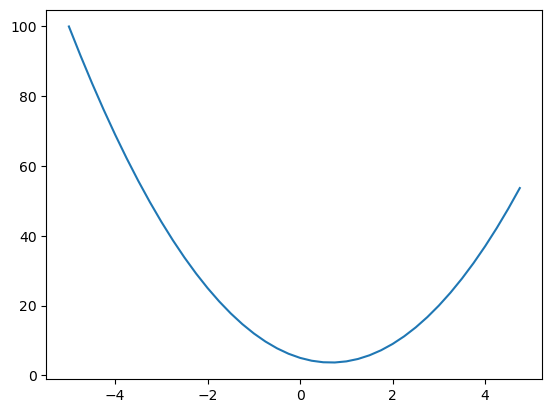

In [238]:
# Create a set of scalar values to feed into f(x)
xs = np.arange(-5, 5, 0.25)

# Apply f(x) to each value in xs
ys = f(xs)

# Plot the results
plt.plot(xs, ys)

In [239]:
# We can basically evaluate the derivate here numerically by taking a very small h
h = 0.0001
x = 2/3
(f(x + h) - f(x)) / h # the function respond positively

0.0002999999981767587

In [240]:
# lets get more complex
a = 2.0
b = -3.0
c = 10
d = a * b + c
print(d)

4.0


In [241]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10
d1 = a * b + c
a += h
d2 = a * b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [242]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # 实现反向运算
        return self.__mul__(other)
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()
        topo

In [ ]:
from graphviz import Digraph

def trace(root):
    # builds a set of all node and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for many value in graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node for it 
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)   

    return dot

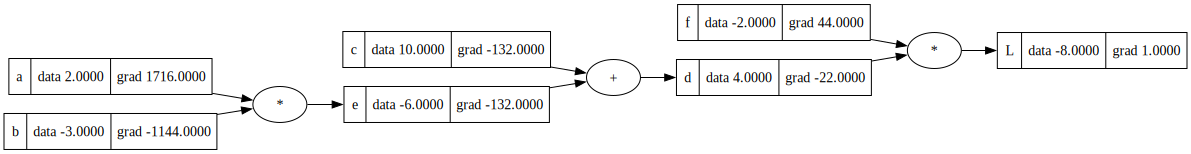

In [ ]:
L.backward()
draw_dot(L)

In [ ]:
def lol():

    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data 

    print((L2 - L1) / h)

lol()

-4.000000000008441


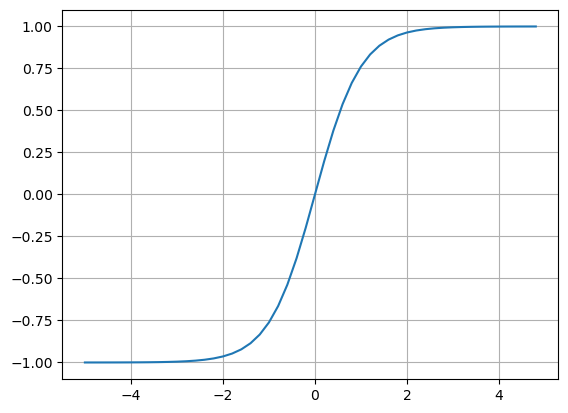

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2, 每个输入的突触强度
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b 偏置
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # 细胞体的原始激活值

o = n.tanh(); o.label = 'o'
o.backward()

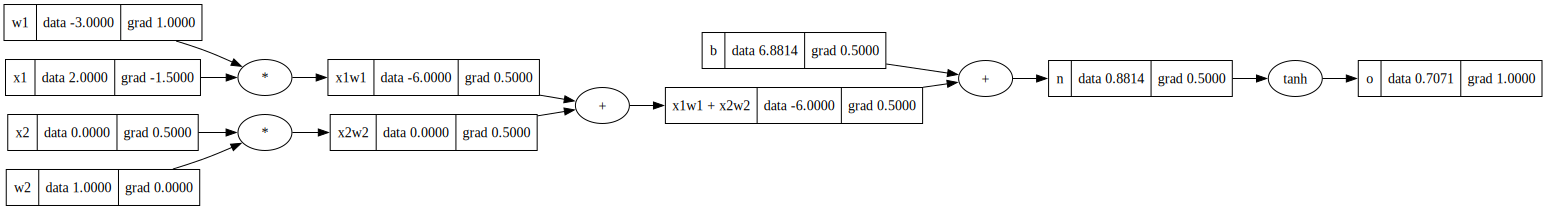

In [ ]:
draw_dot(o)

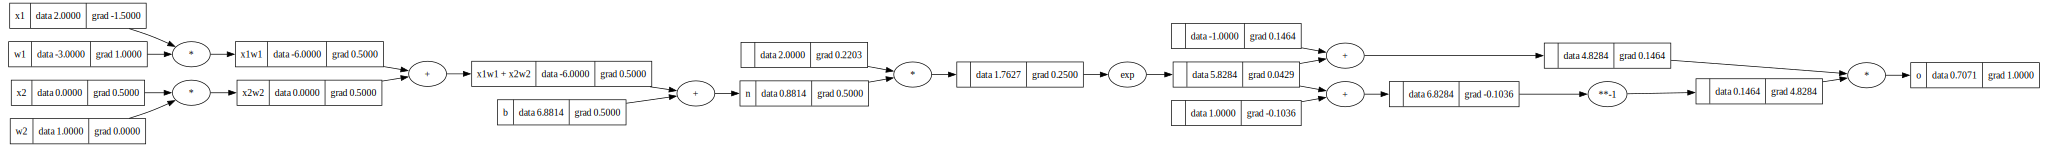

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2, 每个输入的突触强度
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b 偏置
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # 细胞体的原始激活值

# ----
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label='o'
# ----
o.backward()
draw_dot(o)